<a href="https://colab.research.google.com/github/Abdulsalam223/Facial/blob/main/Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("DISEASE PREDICTION SYSTEM - MULTI-DISEASE CLASSIFICATION")
print("=" * 80)

DISEASE PREDICTION SYSTEM - MULTI-DISEASE CLASSIFICATION


In [ ]:
print("=" * 80)
print("DISEASE PREDICTION SYSTEM - MULTI-DISEASE CLASSIFICATION")
print("=" * 80)

# ============================================================================
# STEP 1: DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: LOADING DATASETS")
print("=" * 80)

# Load datasets
heart_df = pd.read_csv('heart.csv')
diabetes_df = pd.read_csv('diabetes.csv')
breast_cancer_df = pd.read_csv('breast-cancer.csv')

datasets = {
    'Heart Disease': heart_df,
    'Diabetes': diabetes_df,
    'Breast Cancer': breast_cancer_df
}

# Initial exploration
for name, df in datasets.items():
    print(f"\n{name} Dataset:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list()}")
    print(f"  Missing values: {df.isnull().sum().sum()}")
    print(f"  First few rows:\n{df.head(2)}")

DISEASE PREDICTION SYSTEM - MULTI-DISEASE CLASSIFICATION

STEP 1: LOADING DATASETS

Heart Disease Dataset:
  Shape: (1025, 14)
  Columns: []
  Missing values: 0
  First few rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   

   ca  thal  target  
0   2     3       0  
1   0     3       0  

Diabetes Dataset:
  Shape: (768, 9)
  Columns: []
  Missing values: 0
  First few rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  

Breast Cancer Dataset:
  Shape: (569, 32)
  Columns: []
  Missing values

In [ ]:
# ============================================================================
# STEP 2: DATA CLEANING AND PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: DATA CLEANING AND PREPROCESSING")
print("=" * 80)

def clean_dataset(df, target_col, dataset_name):
    """Clean and preprocess dataset"""
    print(f"\nCleaning {dataset_name} dataset...")

    # Make a copy
    df_clean = df.copy()

    # Handle missing values
    missing = df_clean.isnull().sum()
    if missing.sum() > 0:
        print(f"  Missing values found: {missing[missing > 0].to_dict()}")
        # Fill numerical with median, categorical with mode
        for col in df_clean.columns:
            if df_clean[col].isnull().any():
                if df_clean[col].dtype in ['float64', 'int64']:
                    df_clean[col].fillna(df_clean[col].median(), inplace=True)
                else:
                    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    else:
        print("  No missing values found")

    # Remove duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        print(f"  Removing {duplicates} duplicate rows")
        df_clean = df_clean.drop_duplicates()

    # Handle outliers using IQR method (optional, can be commented out)
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    numerical_cols = [col for col in numerical_cols if col != target_col]

    print(f"  Dataset shape after cleaning: {df_clean.shape}")

    return df_clean

# Clean all datasets
# Note: Adjust target column names based on your actual data
heart_clean = clean_dataset(heart_df, 'target', 'Heart Disease')
diabetes_clean = clean_dataset(diabetes_df, 'Outcome', 'Diabetes')
breast_cancer_clean = clean_dataset(breast_cancer_df, 'diagnosis', 'Breast Cancer')


STEP 2: DATA CLEANING AND PREPROCESSING

Cleaning Heart Disease dataset...
  No missing values found
  Removing 723 duplicate rows
  Dataset shape after cleaning: (302, 14)

Cleaning Diabetes dataset...
  No missing values found
  Dataset shape after cleaning: (768, 9)

Cleaning Breast Cancer dataset...
  No missing values found
  Dataset shape after cleaning: (569, 32)



STEP 3: EXPLORATORY DATA ANALYSIS


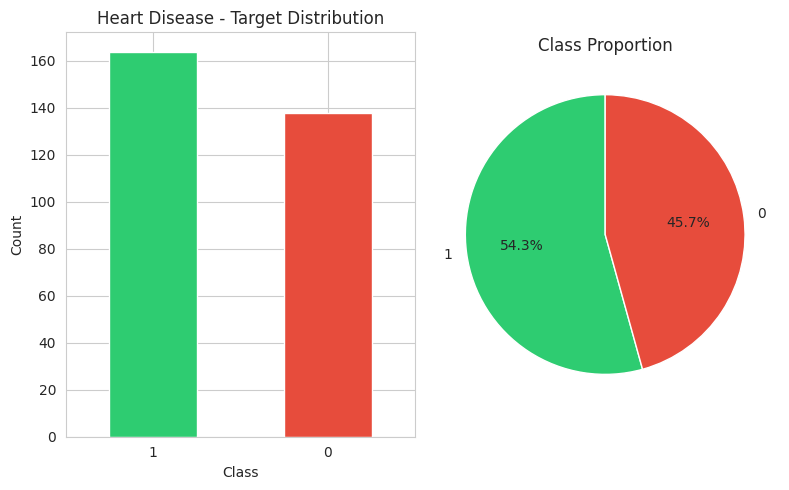


Heart Disease Class Distribution:
target
1    164
0    138
Name: count, dtype: int64
Class Balance: 84.15%


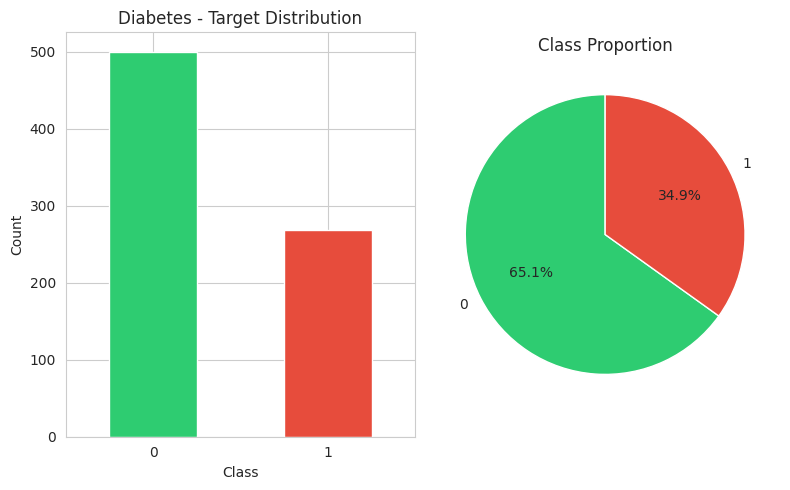


Diabetes Class Distribution:
Outcome
0    500
1    268
Name: count, dtype: int64
Class Balance: 53.60%


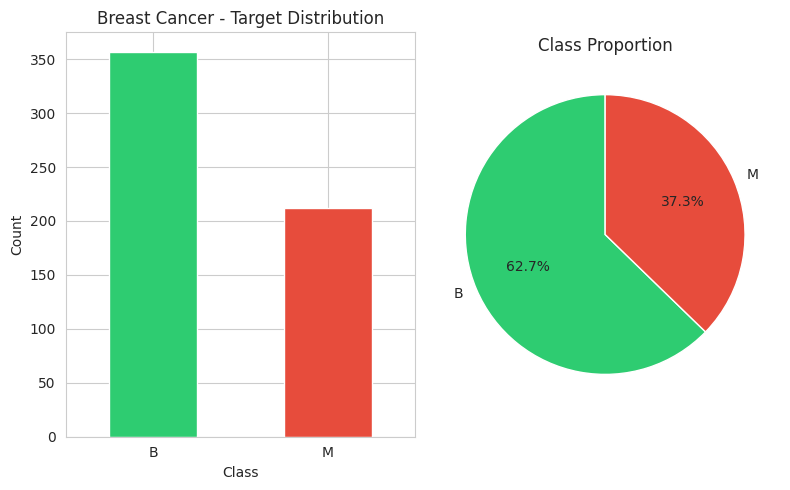


Breast Cancer Class Distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64
Class Balance: 59.38%


In [ ]:
# ============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

def plot_target_distribution(df, target_col, dataset_name):
    """Plot target variable distribution"""
    plt.figure(figsize=(8, 5))

    counts = df[target_col].value_counts()
    plt.subplot(1, 2, 1)
    counts.plot(kind='bar', color=['#2ecc71', '#e74c3c'])
    plt.title(f'{dataset_name} - Target Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
    plt.title('Class Proportion')

    plt.tight_layout()
    plt.show()

    print(f"\n{dataset_name} Class Distribution:")
    print(counts)
    print(f"Class Balance: {(counts.min() / counts.max() * 100):.2f}%")

# Plot distributions
plot_target_distribution(heart_clean, 'target', 'Heart Disease')
plot_target_distribution(diabetes_clean, 'Outcome', 'Diabetes')
plot_target_distribution(breast_cancer_clean, 'diagnosis', 'Breast Cancer')

# Correlation heatmap for Heart Disease (example)
plt.figure(figsize=(14, 10))
correlation = heart_clean.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Heart Disease - Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# STEP 4: FEATURE ENGINEERING AND PREPARATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: FEATURE ENGINEERING")
print("=" * 80)

def prepare_features(df, target_col, dataset_name):
    """Prepare features for modeling"""
    print(f"\nPreparing {dataset_name} features...")

    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode target if necessary (for breast cancer M/B to 1/0)
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
        print(f"  Encoded target: {dict(zip(le.classes_, le.transform(le.classes_)))}")

    # Encode categorical features if any
    categorical_cols = X.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"  Encoding categorical columns: {list(categorical_cols)}")
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])

    print(f"  Feature shape: {X.shape}")
    print(f"  Target shape: {y.shape}")
    print(f"  Feature names: {list(X.columns)}")

    return X, y

# Prepare all datasets
X_heart, y_heart = prepare_features(heart_clean, 'target', 'Heart Disease')
X_diabetes, y_diabetes = prepare_features(diabetes_clean, 'Outcome', 'Diabetes')
X_breast, y_breast = prepare_features(breast_cancer_clean, 'diagnosis', 'Breast Cancer')

In [ ]:
# ============================================================================
# STEP 5: MODEL TRAINING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: MODEL TRAINING")
print("=" * 80)

def train_models(X, y, dataset_name):
    """Train multiple models and compare performance"""
    print(f"\nTraining models for {dataset_name
                                   }...")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42)
    }

    results = {}
    trained_models = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n  Training {name}...")

        # Train
        model.fit(X_train_scaled, y_train)

        # Predict
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        trained_models[name] = model

        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    Precision: {precision:.4f}")
        print(f"    Recall: {recall:.4f}")
        print(f"    F1-Score: {f1:.4f}")
        print(f"    ROC-AUC: {roc_auc:.4f}")
        print(f"    CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    return results, trained_models, X_test, y_test, X_test_scaled, scaler

# Train models for all datasets
heart_results, heart_models, X_test_heart, y_test_heart, X_test_heart_scaled, scaler_heart = \
    train_models(X_heart, y_heart, 'Heart Disease')

diabetes_results, diabetes_models, X_test_diabetes, y_test_diabetes, X_test_diabetes_scaled, scaler_diabetes = \
    train_models(X_diabetes, y_diabetes, 'Diabetes')

breast_results, breast_models, X_test_breast, y_test_breast, X_test_breast_scaled, scaler_breast = \
    train_models(X_breast, y_breast, 'Breast Cancer')



STEP 5: MODEL TRAINING

Training models for Heart Disease...

  Training Logistic Regression...
    Accuracy: 0.8098
    Precision: 0.7619
    Recall: 0.9143
    F1-Score: 0.8312
    ROC-AUC: 0.9298
    CV Score: 0.8439 (+/- 0.0240)

  Training SVM...
    Accuracy: 0.9268
    Precision: 0.9167
    Recall: 0.9429
    F1-Score: 0.9296
    ROC-AUC: 0.9771
    CV Score: 0.9122 (+/- 0.0195)

  Training Random Forest...
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    ROC-AUC: 1.0000
    CV Score: 0.9817 (+/- 0.0164)

  Training XGBoost...
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    ROC-AUC: 1.0000
    CV Score: 0.9866 (+/- 0.0105)

Training models for Diabetes...

  Training Logistic Regression...
    Accuracy: 0.7143
    Precision: 0.6087
    Recall: 0.5185
    F1-Score: 0.5600
    ROC-AUC: 0.8230
    CV Score: 0.7785 (+/- 0.0126)

  Training SVM...
    Accuracy: 0.7532
    Precision: 0.6600
    Recall: 0.611


STEP 6: MODEL EVALUATION AND COMPARISON


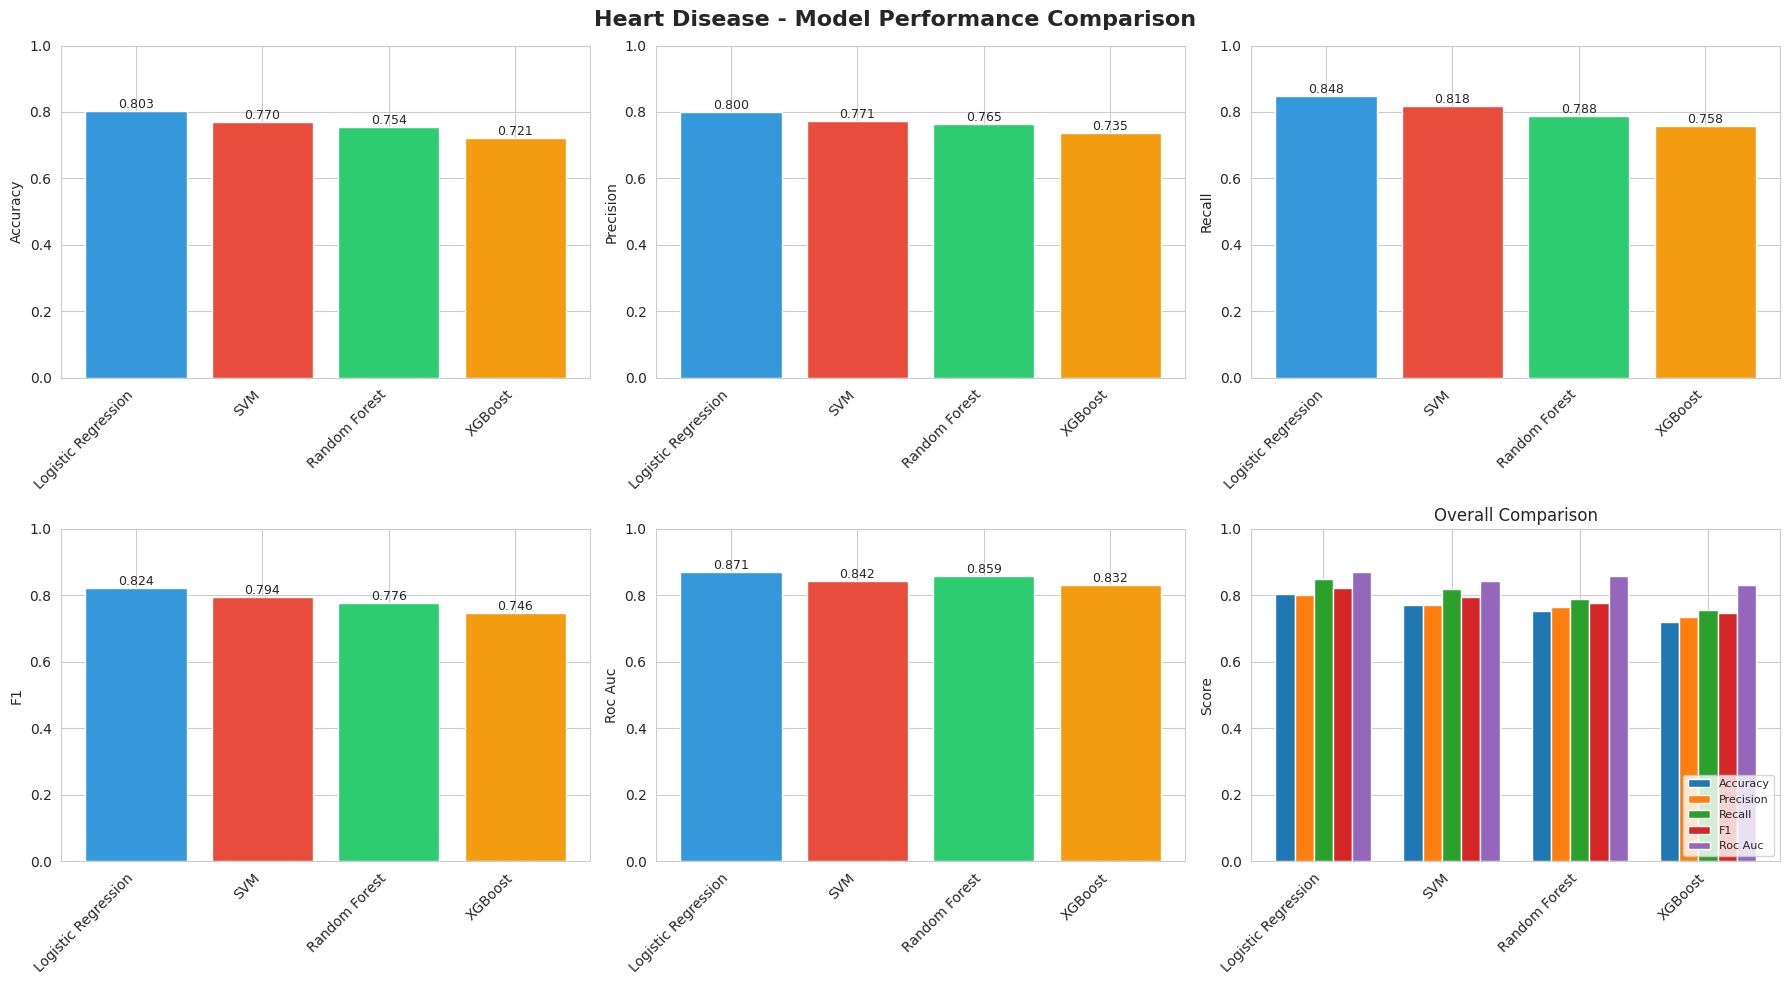

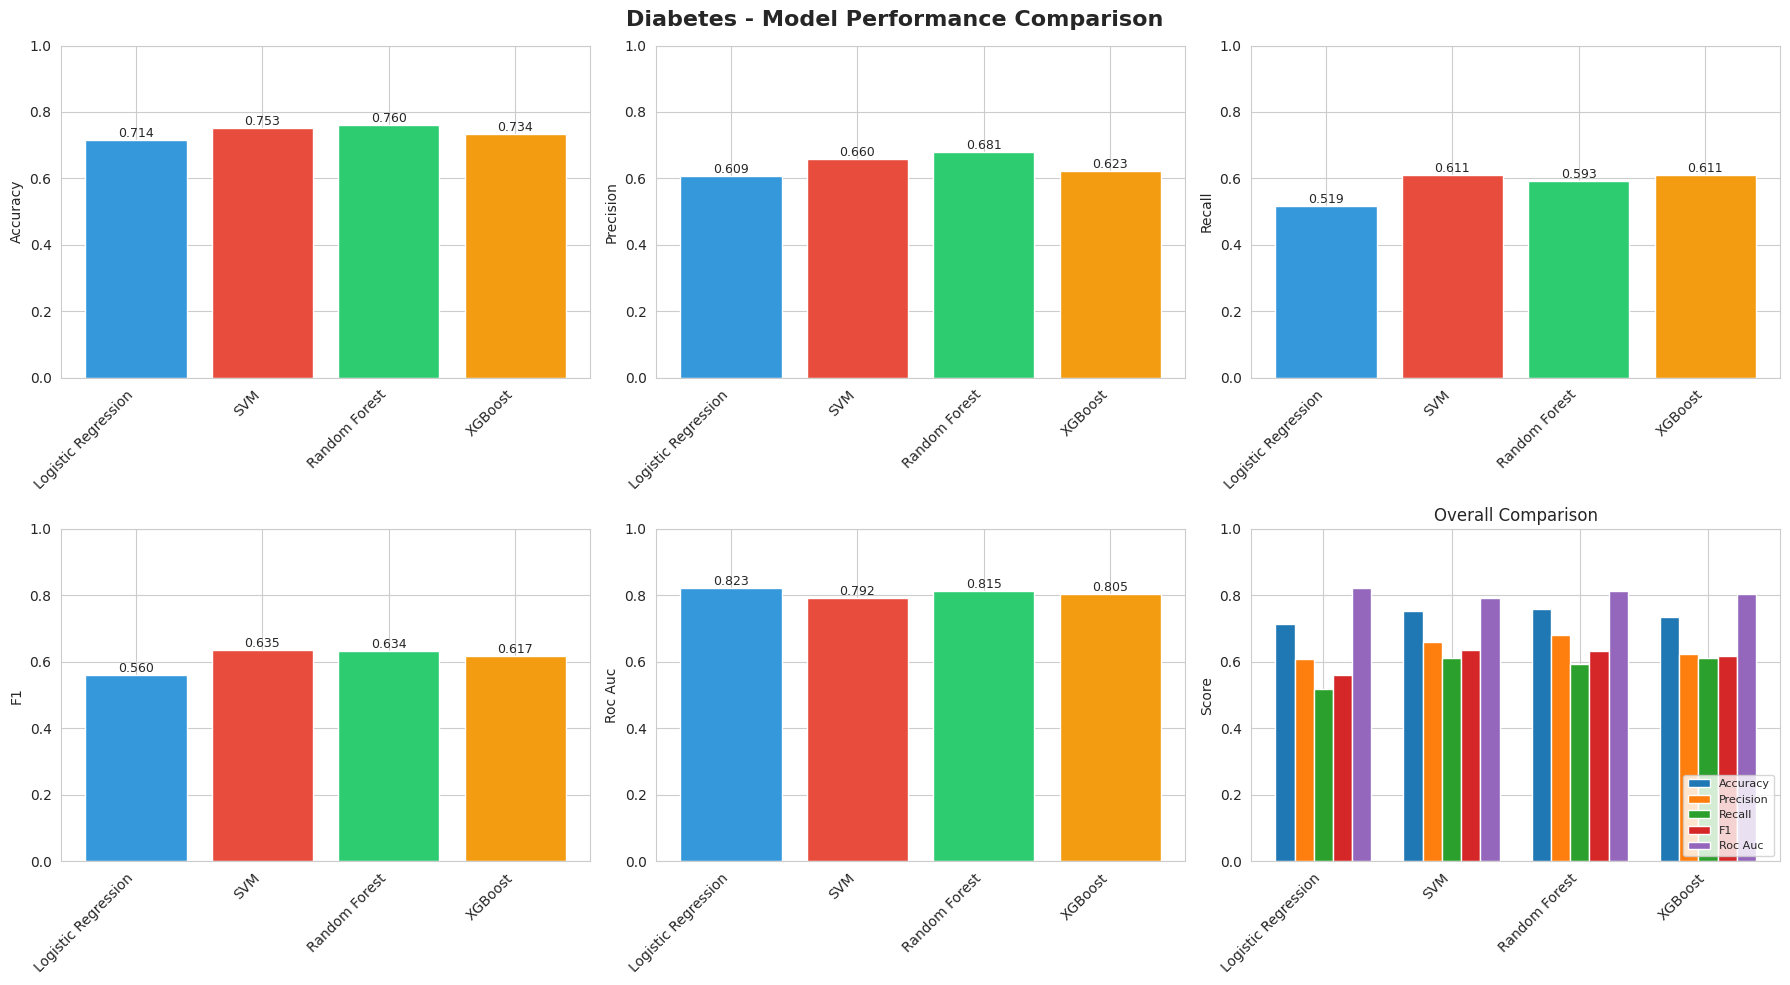

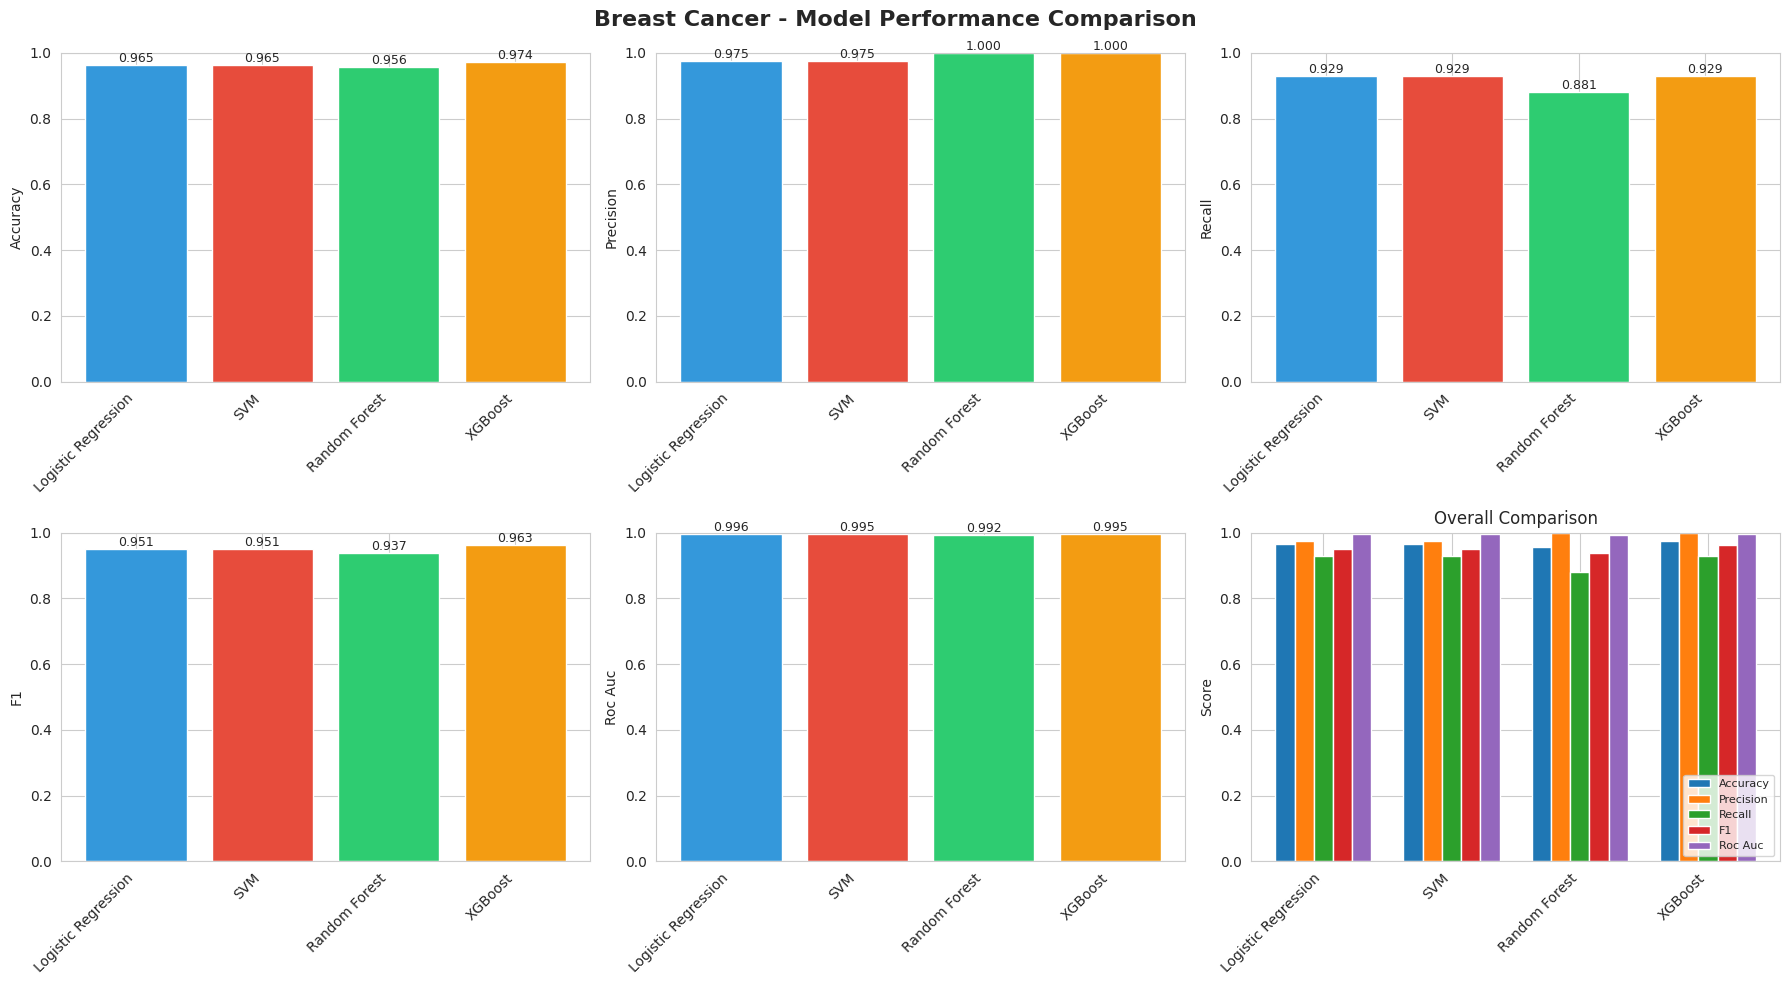


STEP 7: DETAILED EVALUATION VISUALIZATIONS


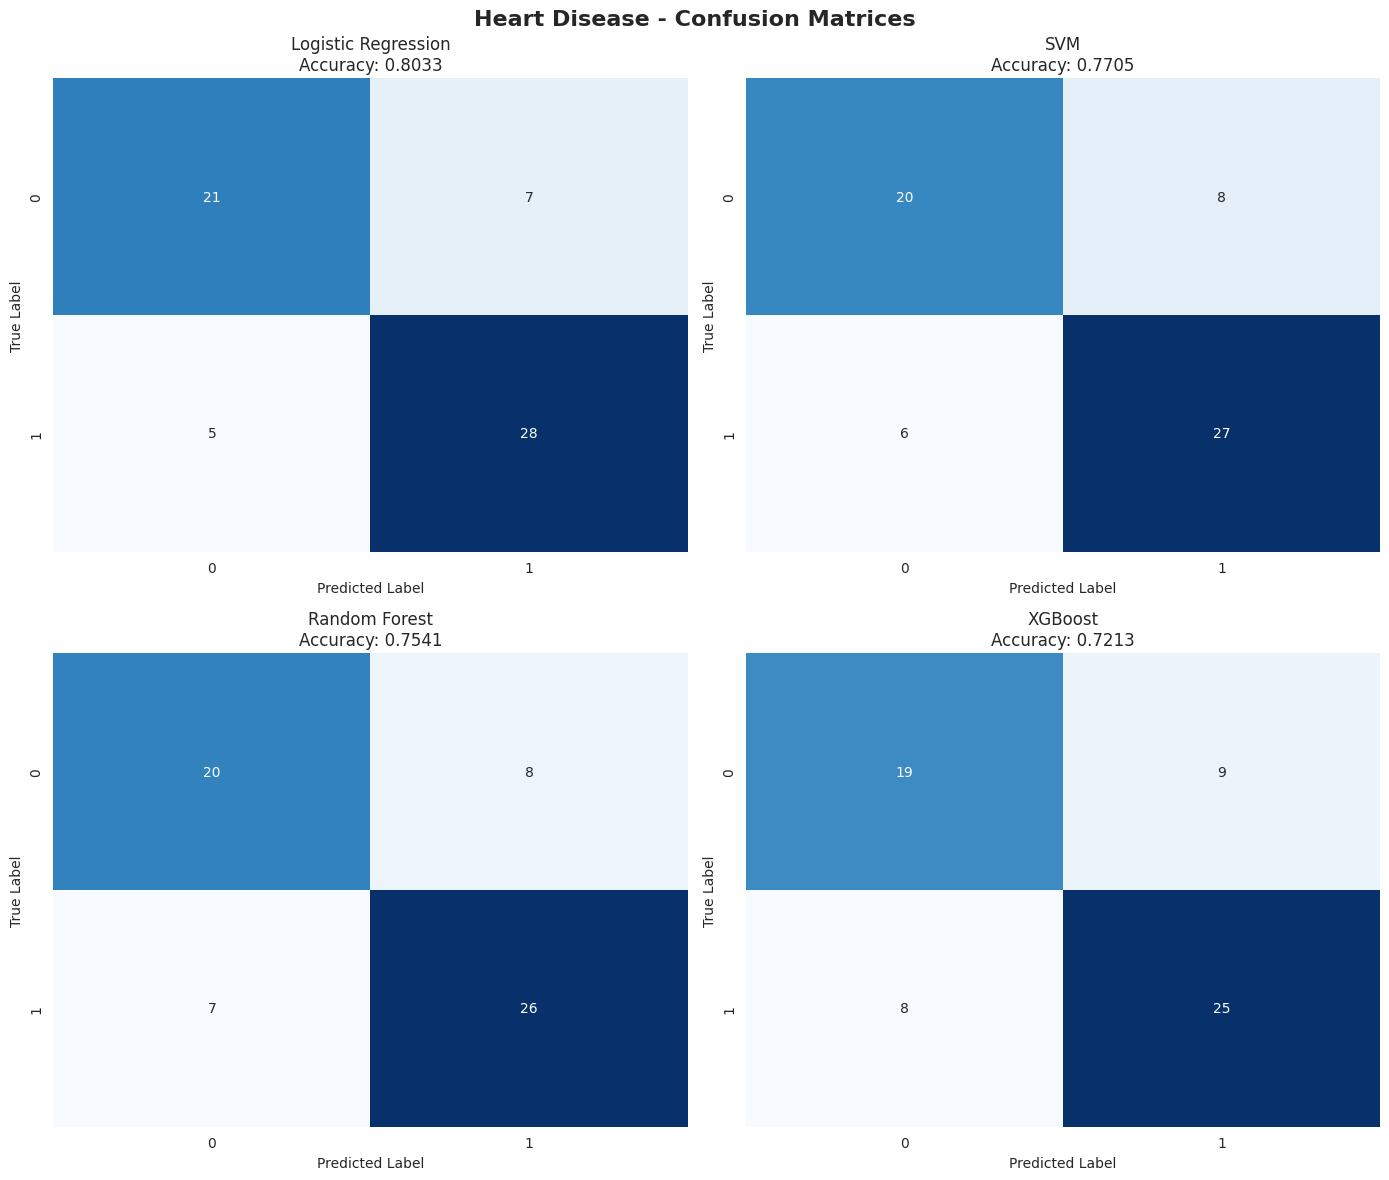

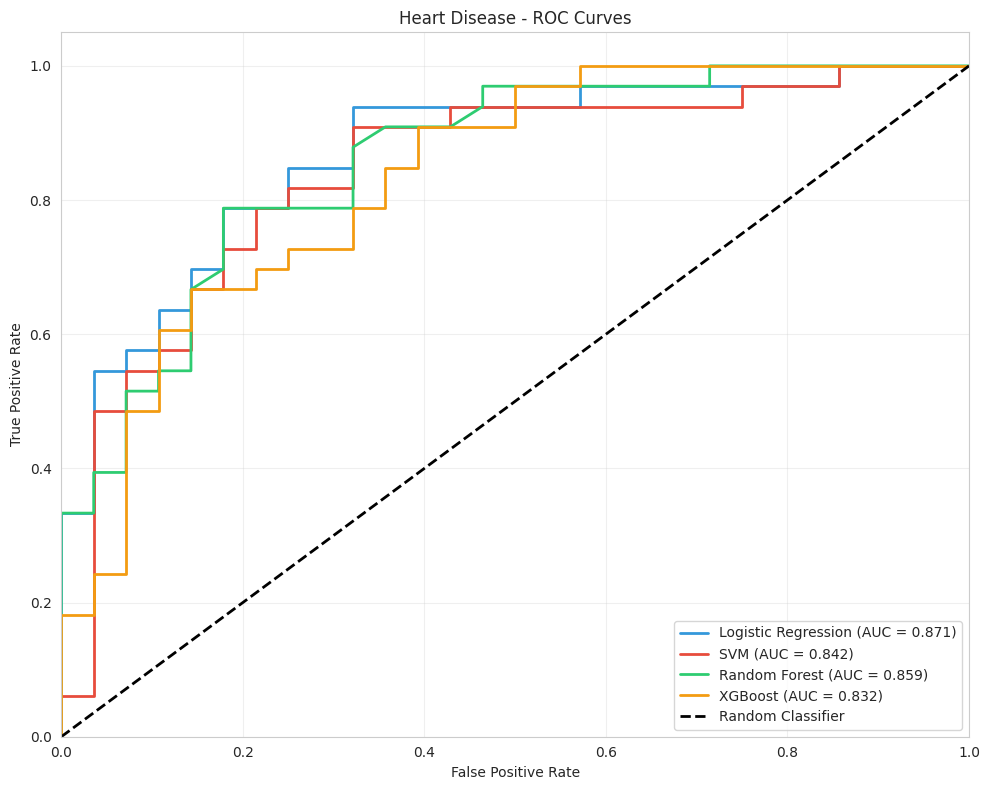

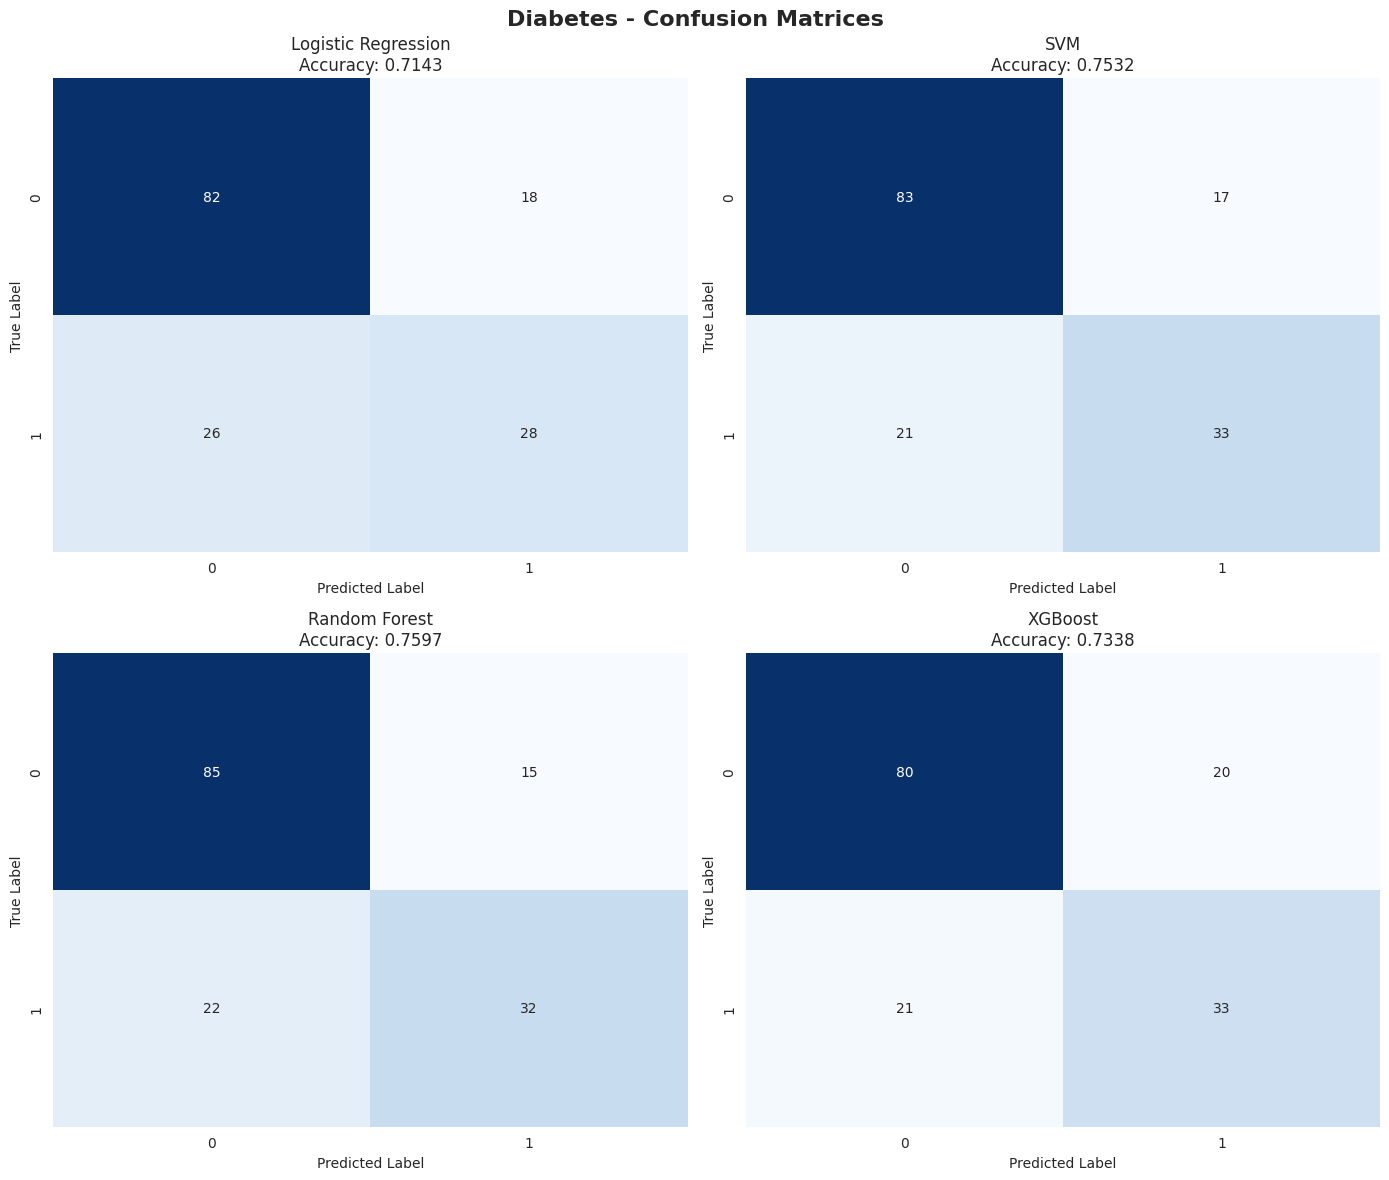

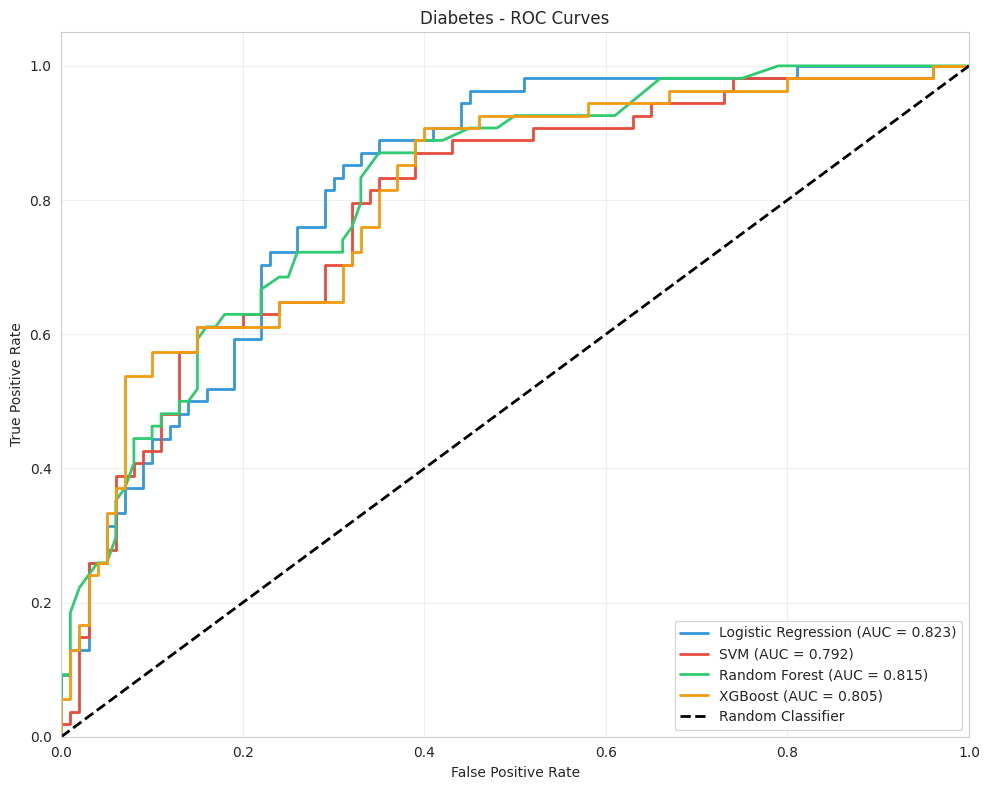

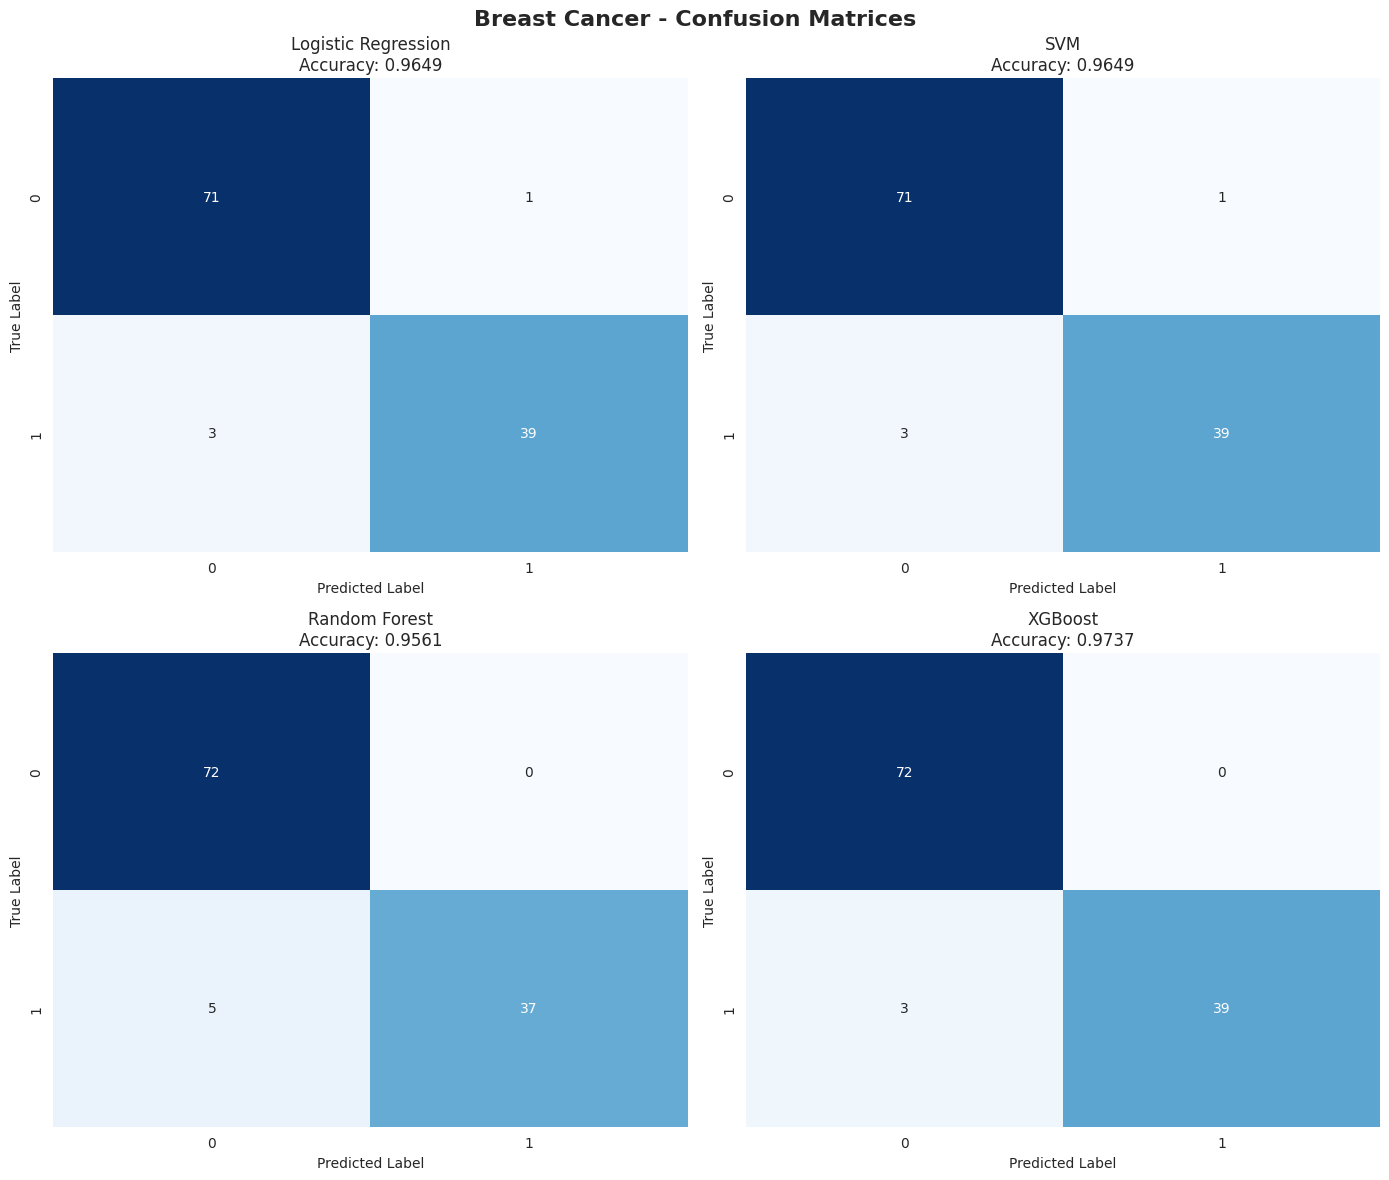

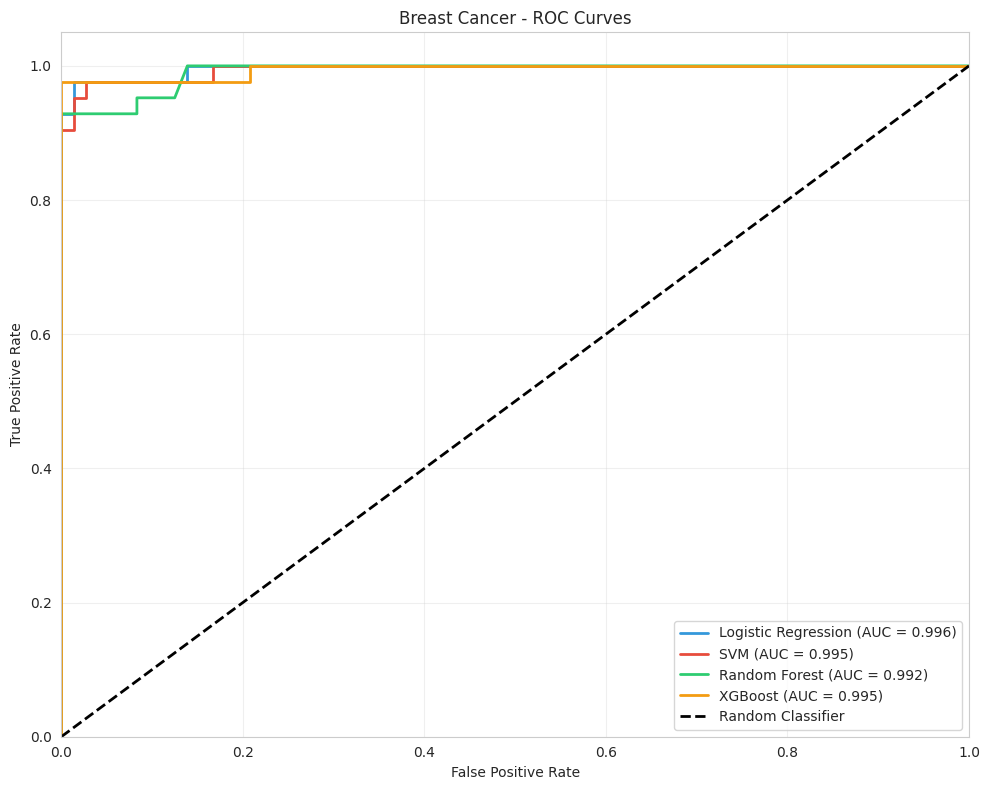

In [ ]:
# ============================================================================
# STEP 6: MODEL EVALUATION AND COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6: MODEL EVALUATION AND COMPARISON")
print("=" * 80)

def plot_model_comparison(results, dataset_name):
    """Plot comparison of model performance"""

    # Prepare data
    models = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    data = {metric: [results[model][metric] for model in models] for metric in metrics}

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{dataset_name} - Model Performance Comparison', fontsize=16, fontweight='bold')

    # Individual metric plots
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        bars = ax.bar(models, data[metric], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_ylim([0, 1])
        ax.set_xticklabels(models, rotation=45, ha='right')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # Overall comparison
    ax = axes[1, 2]
    x = np.arange(len(models))
    width = 0.15

    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, data[metric], width, label=metric.replace('_', ' ').title())

    ax.set_ylabel('Score')
    ax.set_title('Overall Comparison')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(loc='lower right', fontsize=8)
    ax.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

# Plot comparisons
plot_model_comparison(heart_results, 'Heart Disease')
plot_model_comparison(diabetes_results, 'Diabetes')
plot_model_comparison(breast_results, 'Breast Cancer')

# ============================================================================
# STEP 7: DETAILED EVALUATION VISUALIZATIONS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 7: DETAILED EVALUATION VISUALIZATIONS")
print("=" * 80)

def plot_confusion_matrices(results, y_test, dataset_name):
    """Plot confusion matrices for all models"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'{dataset_name} - Confusion Matrices', fontsize=16, fontweight='bold')

    for idx, (name, result) in enumerate(results.items()):
        ax = axes[idx // 2, idx % 2]
        cm = confusion_matrix(y_test, result['y_pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'{name}\nAccuracy: {result["accuracy"]:.4f}')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

def plot_roc_curves(results, y_test, dataset_name):
    """Plot ROC curves for all models"""

    plt.figure(figsize=(10, 8))

    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

    for idx, (name, result) in enumerate(results.items()):
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = result['roc_auc']

        plt.plot(fpr, tpr, color=colors[idx], lw=2,
                label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} - ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot for all datasets
plot_confusion_matrices(heart_results, y_test_heart, 'Heart Disease')
plot_roc_curves(heart_results, y_test_heart, 'Heart Disease')

plot_confusion_matrices(diabetes_results, y_test_diabetes, 'Diabetes')
plot_roc_curves(diabetes_results, y_test_diabetes, 'Diabetes')

plot_confusion_matrices(breast_results, y_test_breast, 'Breast Cancer')
plot_roc_curves(breast_results, y_test_breast, 'Breast Cancer')



STEP 8: FEATURE IMPORTANCE ANALYSIS

Heart Disease:


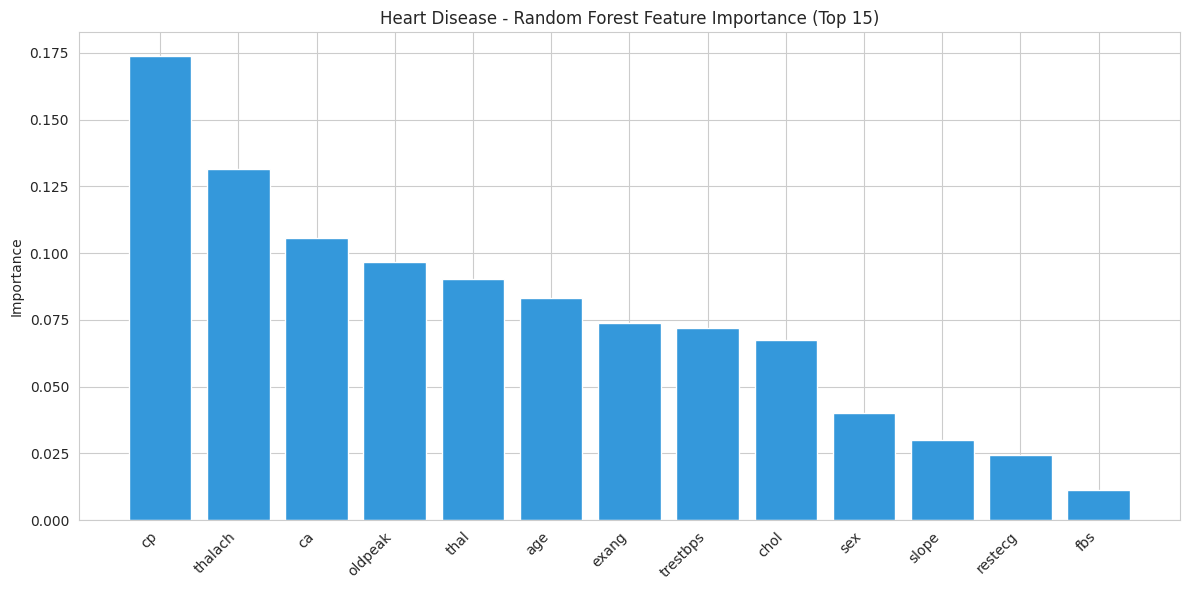


Top 10 important features for Random Forest:
  1. cp: 0.1740
  2. thalach: 0.1316
  3. ca: 0.1057
  4. oldpeak: 0.0966
  5. thal: 0.0904
  6. age: 0.0830
  7. exang: 0.0737
  8. trestbps: 0.0721
  9. chol: 0.0674
  10. sex: 0.0402


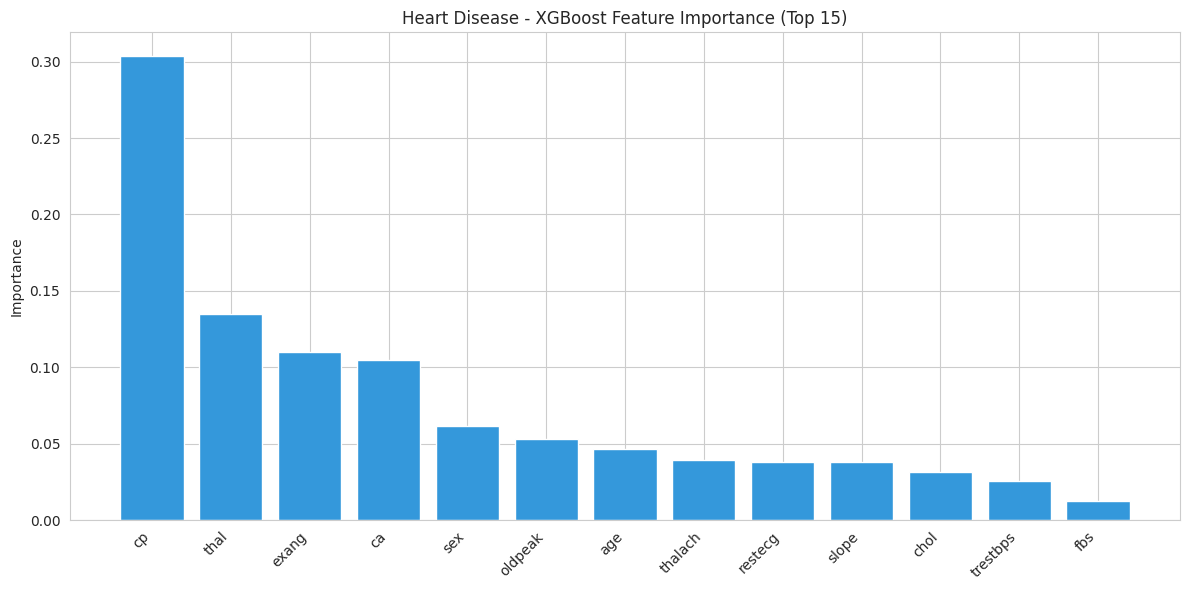


Top 10 important features for XGBoost:
  1. cp: 0.3040
  2. thal: 0.1351
  3. exang: 0.1102
  4. ca: 0.1046
  5. sex: 0.0613
  6. oldpeak: 0.0528
  7. age: 0.0467
  8. thalach: 0.0392
  9. restecg: 0.0382
  10. slope: 0.0381

Diabetes:


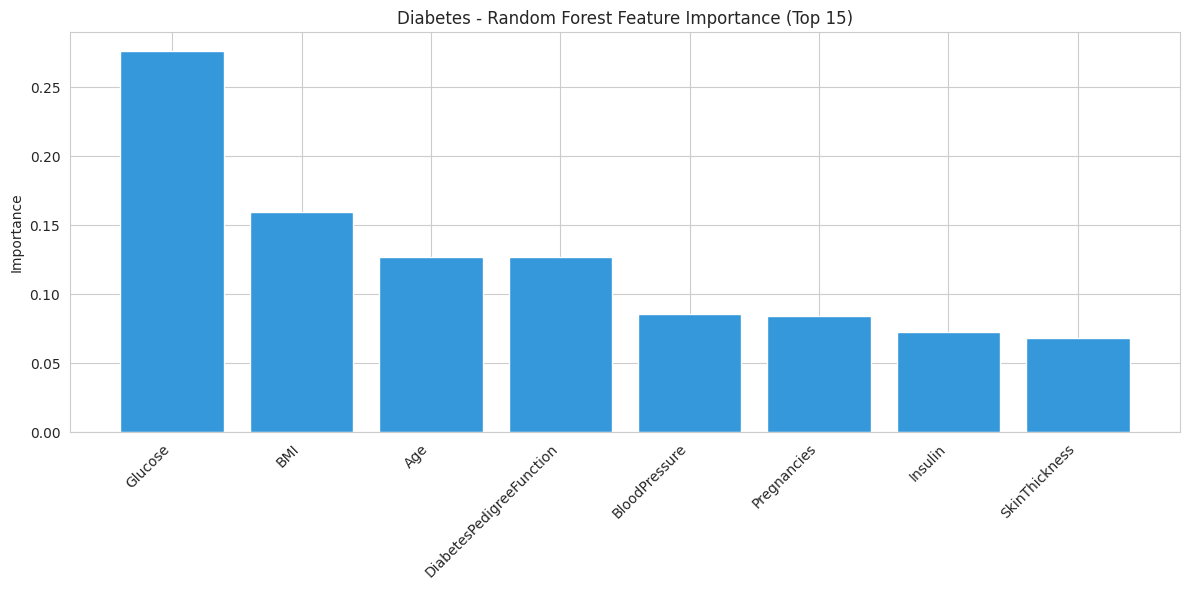


Top 10 important features for Random Forest:
  1. Glucose: 0.2760
  2. BMI: 0.1595
  3. Age: 0.1272
  4. DiabetesPedigreeFunction: 0.1267
  5. BloodPressure: 0.0856
  6. Pregnancies: 0.0845
  7. Insulin: 0.0724
  8. SkinThickness: 0.0680


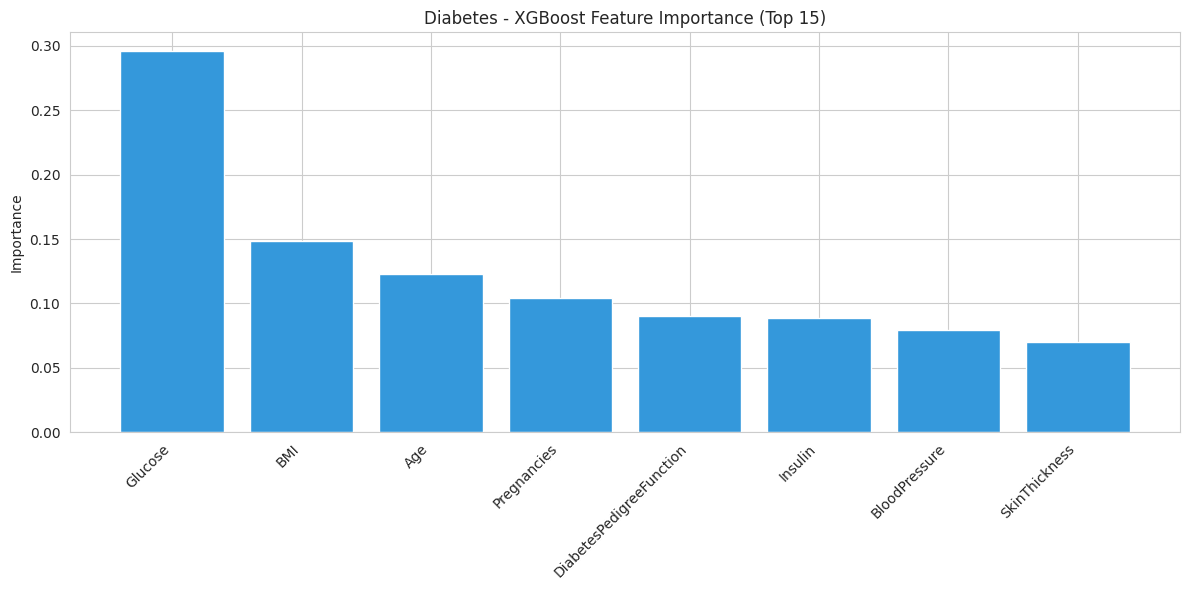


Top 10 important features for XGBoost:
  1. Glucose: 0.2957
  2. BMI: 0.1488
  3. Age: 0.1229
  4. Pregnancies: 0.1041
  5. DiabetesPedigreeFunction: 0.0900
  6. Insulin: 0.0889
  7. BloodPressure: 0.0795
  8. SkinThickness: 0.0700

Breast Cancer:


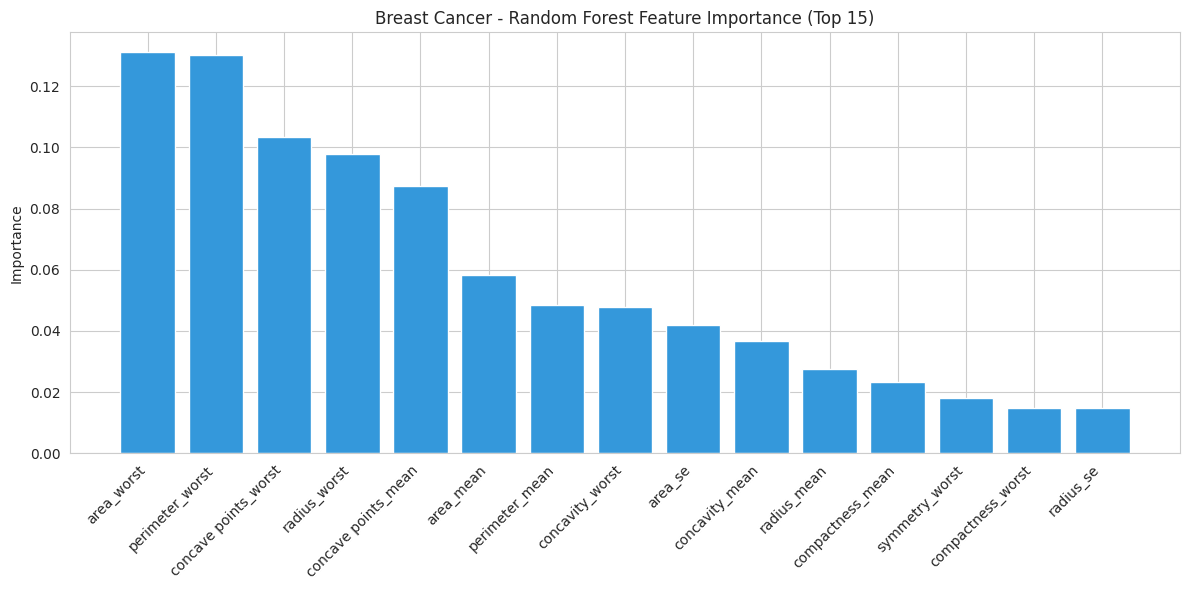


Top 10 important features for Random Forest:
  1. area_worst: 0.1310
  2. perimeter_worst: 0.1303
  3. concave points_worst: 0.1032
  4. radius_worst: 0.0978
  5. concave points_mean: 0.0874
  6. area_mean: 0.0584
  7. perimeter_mean: 0.0484
  8. concavity_worst: 0.0478
  9. area_se: 0.0419
  10. concavity_mean: 0.0366


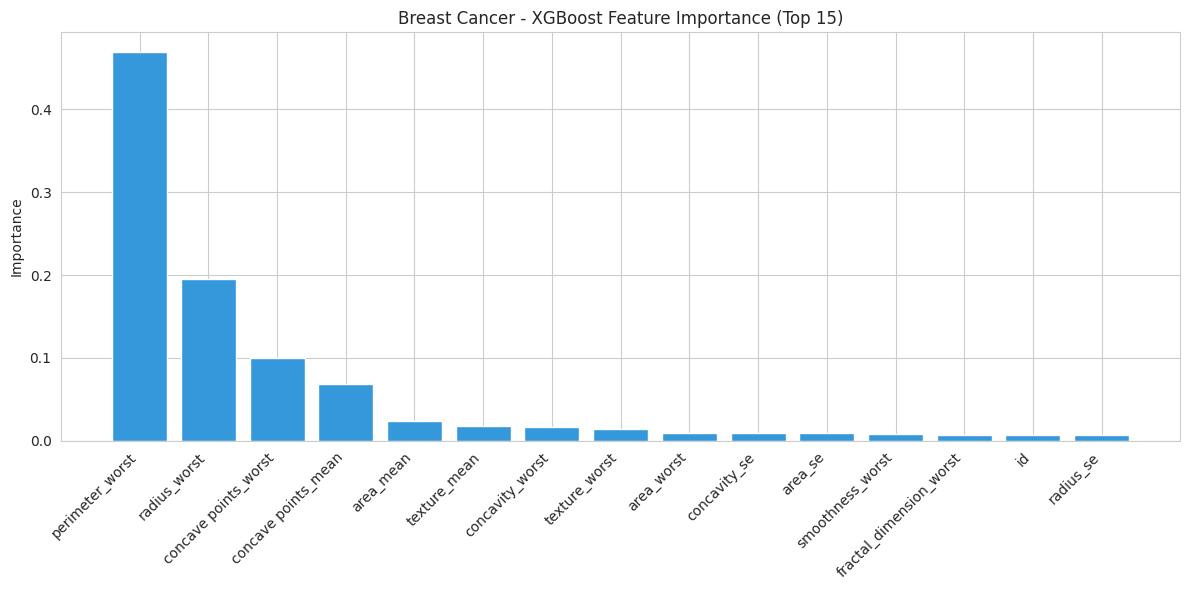


Top 10 important features for XGBoost:
  1. perimeter_worst: 0.4696
  2. radius_worst: 0.1951
  3. concave points_worst: 0.0993
  4. concave points_mean: 0.0682
  5. area_mean: 0.0235
  6. texture_mean: 0.0178
  7. concavity_worst: 0.0167
  8. texture_worst: 0.0142
  9. area_worst: 0.0094
  10. concavity_se: 0.0092


In [ ]:

# ============================================================================
# STEP 8: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 8: FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

def plot_feature_importance(model, feature_names, dataset_name, model_name):
    """Plot feature importance for tree-based models"""

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # Top 15 features

        plt.figure(figsize=(12, 6))
        plt.title(f'{dataset_name} - {model_name} Feature Importance (Top 15)')
        plt.bar(range(len(indices)), importances[indices], color='#3498db')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()

        print(f"\nTop 10 important features for {model_name}:")
        for i in range(min(10, len(indices))):
            print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot feature importance for Random Forest and XGBoost
for dataset_name, models, X in [('Heart Disease', heart_models, X_heart),
                                  ('Diabetes', diabetes_models, X_diabetes),
                                  ('Breast Cancer', breast_models, X_breast)]:
    print(f"\n{dataset_name}:")
    for model_name in ['Random Forest', 'XGBoost']:
        plot_feature_importance(models[model_name], X.columns, dataset_name, model_name)

In [ ]:
# ============================================================================
# STEP 9: FINAL SUMMARY AND BEST MODEL SELECTION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 9: FINAL SUMMARY AND RECOMMENDATIONS")
print("=" * 80)

def print_best_model(results, dataset_name):
    """Print the best performing model"""

    print(f"\n{dataset_name} - Best Model Selection:")
    print("-" * 60)

    # Find best model by F1 score (balanced metric)
    best_model = max(results.items(), key=lambda x: x[1]['f1'])

    print(f"Best Model: {best_model[0]}")
    print(f"  Accuracy:  {best_model[1]['accuracy']:.4f}")
    print(f"  Precision: {best_model[1]['precision']:.4f}")
    print(f"  Recall:    {best_model[1]['recall']:.4f}")
    print(f"  F1-Score:  {best_model[1]['f1']:.4f}")
    print(f"  ROC-AUC:   {best_model[1]['roc_auc']:.4f}")
    print(f"  CV Score:  {best_model[1]['cv_mean']:.4f} (+/- {best_model[1]['cv_std']:.4f})")

# Print best models for each dataset
print_best_model(heart_results, 'Heart Disease')
print_best_model(diabetes_results, 'Diabetes')
print_best_model(breast_results, 'Breast Cancer')

# Create summary table
print("\n" + "=" * 80)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("=" * 80)

summary_data = []
for dataset_name, results in [('Heart Disease', heart_results),
                               ('Diabetes', diabetes_results),
                               ('Breast Cancer', breast_results)]:
    for model_name, metrics in results.items():
        summary_data.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1-Score': f"{metrics['f1']:.4f}",
            'ROC-AUC': f"{metrics['roc_auc']:.4f}"
        })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\nKey Takeaways:")
print("1. All models have been trained and evaluated on three disease datasets")
print("2. Multiple metrics (Accuracy, Precision, Recall, F1, ROC-AUC) provide comprehensive evaluation")
print("3. Cross-validation ensures model reliability and generalization")
print("4. Feature importance analysis identifies key predictive factors")
print("5. Confusion matrices and ROC curves offer detailed performance insights")
print("\nNext Steps:")
print("- Fine-tune hyperparameters for best performing models")
print("- Consider ensemble methods for improved performance")
print("- Deploy the best model for real-world predictions")
print("=" * 80)


STEP 9: FINAL SUMMARY AND RECOMMENDATIONS

Heart Disease - Best Model Selection:
------------------------------------------------------------
Best Model: Logistic Regression
  Accuracy:  0.8033
  Precision: 0.8000
  Recall:    0.8485
  F1-Score:  0.8235
  ROC-AUC:   0.8712
  CV Score:  0.8216 (+/- 0.0210)

Diabetes - Best Model Selection:
------------------------------------------------------------
Best Model: SVM
  Accuracy:  0.7532
  Precision: 0.6600
  Recall:    0.6111
  F1-Score:  0.6346
  ROC-AUC:   0.7924
  CV Score:  0.7541 (+/- 0.0166)

Breast Cancer - Best Model Selection:
------------------------------------------------------------
Best Model: XGBoost
  Accuracy:  0.9737
  Precision: 1.0000
  Recall:    0.9286
  F1-Score:  0.9630
  ROC-AUC:   0.9950
  CV Score:  0.9648 (+/- 0.0213)

COMPREHENSIVE PERFORMANCE SUMMARY

       Dataset               Model Accuracy Precision Recall F1-Score ROC-AUC
Heart Disease Logistic Regression   0.8033    0.8000 0.8485   0.8235  0.8712
Hear